# Parking Lot Recognition (CNN)
(2) 모델 향상

데이터 및 원본 코드 출처: <https://www.kaggle.com/kageyama/keras-car-park-recognition-cnn>  
추가 데이터 출처 : <https://www.kaggle.com/blanderbuss/parking-lot-dataset>

# Preprocessing

In [1]:
# import required packages
import os
import cv2
import random
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import matplotlib.pyplot as plt

In [2]:
# directory
current_path = os.getcwd()
data_DIR = os.path.join(current_path, 'data')
output_DIR = os.path.join(current_path, 'output')

Free_DIR = os.path.join(data_DIR, 'Free')
Full_DIR = os.path.join(data_DIR, 'Full')

UFPR04_rainy_Free = os.path.join(data_DIR, 'UFPR04_rainy_Free')
UFPR04_rainy_Full = os.path.join(data_DIR, 'UFPR04_rainy_Full')
PUCPR_sunny_Free =  os.path.join(data_DIR, 'PUCPR_sunny_Free')
PUCPR_sunny_Full =  os.path.join(data_DIR, 'PUCPR_sunny_Full')

In [3]:
# setting
img_size = 150

X = [] # store image array
Z = [] # store image label

In [4]:
def assign_label(img, label):
    # return label of image file
    return label


def img_load(X, Z, label, DIR):
    # load image file in color and return to np.array
    
    # list files in directory to access
    for img in tqdm(os.listdir(DIR)):
        label = assign_label(img, label)   # assign label
        file_path = os.path.join(DIR, img) # compose path
        
        img = cv2.imread(file_path, cv2.IMREAD_COLOR) # load image
        img = cv2.resize(img, (img_size, img_size))   # resize image
        
        X.append(np.array(img)) # return image as np.array
        Z.append(str(label))    # return image label

In [5]:
# load data
img_load(X, Z, 'Free', Free_DIR)
img_load(X, Z, 'Free', UFPR04_rainy_Free)
img_load(X, Z, 'Free', PUCPR_sunny_Free)
print(len(X))

img_load(X, Z, 'Full', Full_DIR)
img_load(X, Z, 'Full', UFPR04_rainy_Full)
img_load(X, Z, 'Full', PUCPR_sunny_Full)
print(len(X))

  0%|          | 3/2195 [00:00<01:13, 29.91it/s]

1327


100%|██████████| 60/60 [00:00<00:00, 91.60it/s]

3632


In [6]:
# data shape
np.asarray(X).shape

(3632, 150, 150, 3)

In [7]:
# image size
print('전체 이미지 수:', np.asarray(X).shape[0])
print('세로:', np.asarray(X).shape[1])
print('가로:', np.asarray(X).shape[2])
print('채널:', np.asarray(X).shape[3])

전체 이미지 수: 3632
세로: 150
가로: 150
채널: 3


In [8]:
# check X
print('전체 이미지 수:', len(X))
print('세로:', len(X[1]))
print('가로:', len(X[1][1]))
print('세로x가로 첫번째 픽셀값:', X[1][1][1]) # pixcel values for each color channels (RGB)

전체 이미지 수: 3632
세로: 150
가로: 150
세로x가로 첫번째 픽셀값: [ 99  89 112]


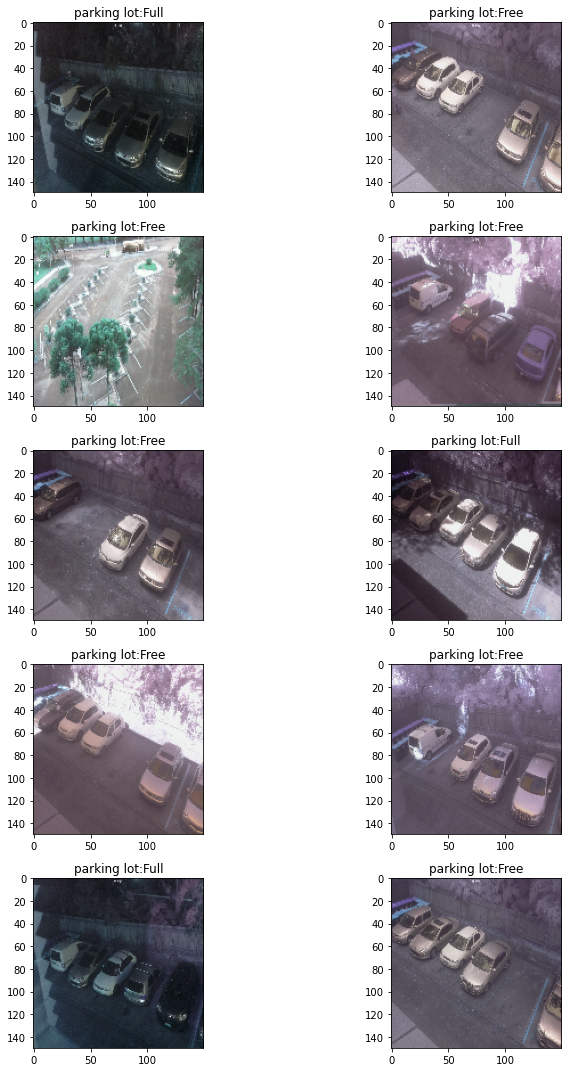

In [9]:
# check 10 random images
fig, ax = plt.subplots(5, 2)
fig.set_size_inches(12, 15)

for i in range(5):
    for j in range(2):
        num = random.randint(0, len(X)) # select random image number
        
        ax[i, j].imshow(X[num])                   # load image
        ax[i, j].set_title('parking lot:'+Z[num]) # attach label

plt.tight_layout()

In [10]:
# label encoder
le = LabelEncoder()
Y = le.fit_transform(Z)
Y = to_categorical(Y, 2)

In [11]:
# convert X
X = np.array(X) # copy
X = X/255       # convert values into range 0~1

In [12]:
# data partition
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.3, random_state=1)

In [13]:
# fix random seed
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)

## CNN

In [14]:
# import required packages
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Activation, Dense, Dropout
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

In [15]:
# CNN modeling
# stack convolution layer and pooling layer
model = Sequential()

# layer1
model.add(Conv2D(filters=32,
                 kernel_size=(5, 5),
                 padding='Same',
                 activation='relu',
                 input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# layer2
model.add(Conv2D(filters=64,
                 kernel_size=(3, 3),
                 padding='Same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))

# layer3
model.add(Conv2D(filters=96,
                 kernel_size=(3, 3),
                 padding='Same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))

# layer4
model.add(Conv2D(filters=96,
                 kernel_size=(3, 3),
                 padding='Same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.3))  # add dropout to prevent overfitting
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(2, activation='softmax'))

In [16]:
# use callback to increase learning rate
red_lr = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.1)

In [17]:
# data augmentation to prevent overfitting
datagen = ImageDataGenerator(featurewise_center=False,            #set input mean to 0 over the dataset
                             samplewise_center=False,             #set each sample mean to 0
                             featurewise_std_normalization=False, #divide inputs by std of the dataset
                             samplewise_std_normalization=False,  #divide each input by its std
                             zca_whitening=False,                 #apply ZCA whitening
                             rotation_range=10,                   #randomly rotate images
                             zoom_range = 0.1,                    #Randomly zoom image
                             width_shift_range=0.2,               #randomly shift images horizontally
                             height_shift_range=0.2,              #randomly shift images vertically
                             horizontal_flip=True,                #randomly flip images
                             vertical_flip=False)                 #randomly flip images

datagen.fit(X_train)

In [18]:
# compiling model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 96)        55392     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 96)        8

## Training

In [20]:
# training conditions
batch_size = 128
epochs = 30

In [21]:
# training
History = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                              epochs=epochs,
                              validation_data=(X_valid, y_valid),
                              verbose=1,
                              steps_per_epoch=X_train.shape[0]//batch_size)

/Users/samantha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
19/19 [==============================] - 133s 7s/step - loss: 0.8680 - accuracy: 0.6550 - val_loss: 0.5945 - val_accuracy: 0.7404
Epoch 2/30
19/19 [==============================] - 118s 6s/step - loss: 0.5939 - accuracy: 0.6920 - val_loss: 0.5401 - val_accuracy: 0.7532
Epoch 3/30
19/19 [==============================] - 111s 6s/step - loss: 0.5746 - accuracy: 0.6893 - val_loss: 0.5613 - val_accuracy: 0.7037
Epoch 4/30
19/19 [==============================] - 110s 6s/step - loss: 0.5609 - accuracy: 0.6991 - val_loss: 0.5221 - val_accuracy: 0.7560
Epoch 5/30
19/19 [==============================] - 551s 30s/step - loss: 0.5282 - accuracy: 0.7407 - val_loss: 0.4778 - val_accuracy: 0.7807
Epoch 6/30
19/19 [==============================] - 113s 6s/step - loss: 0.5091 - accuracy: 0.7630 - val_loss: 0.4993 - val_accuracy: 0.7761
Epoch 7/30
19/19 [==============================] - 111s 6s/step - loss: 0.4987 - accuracy: 0.7697 - val_loss: 0.4563 - val_accuracy: 0.8046
Epoch 8/30
1

In [22]:
# save model
model.save(output_DIR+'/cnn2.h5')

## Evaluation

In [23]:
# import required packages
import warnings
warnings.filterwarnings('always', 'ignore')

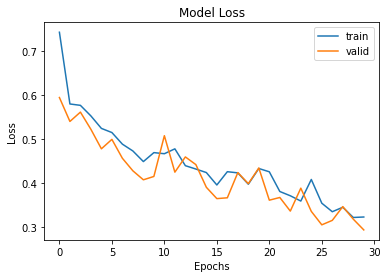

In [24]:
# loss
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'valid'])
plt.show()

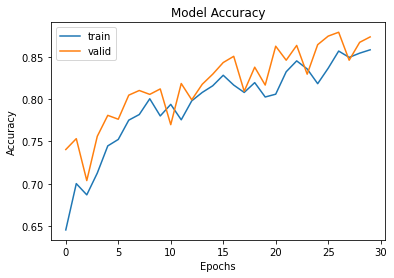

In [25]:
# accuracy
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'valid'])
plt.show()

In [26]:
# accuracy and loss
print('Accuracy: {:.2f}'.format(History.history['accuracy'][9]))
print('Loss: {:.2f}'.format(History.history['loss'][9]))

Accuracy: 0.78
Loss: 0.47


In [27]:
# predict valid set
pred = model.predict(X_valid)
pred_digits = np.argmax(pred, axis=1)

In [28]:
# classified indexes
i = 0
acc = 0
prop_class = []
mis_class = []

for i in range(len(y_valid)):
    if(np.argmax(y_valid[i]) == pred_digits[i]):  # if actual and prection has same index
        prop_class.append(i)                      # predicted properly
        acc += 1                                  # count
    else:
        mis_class.append(i)                       # predicted wrong

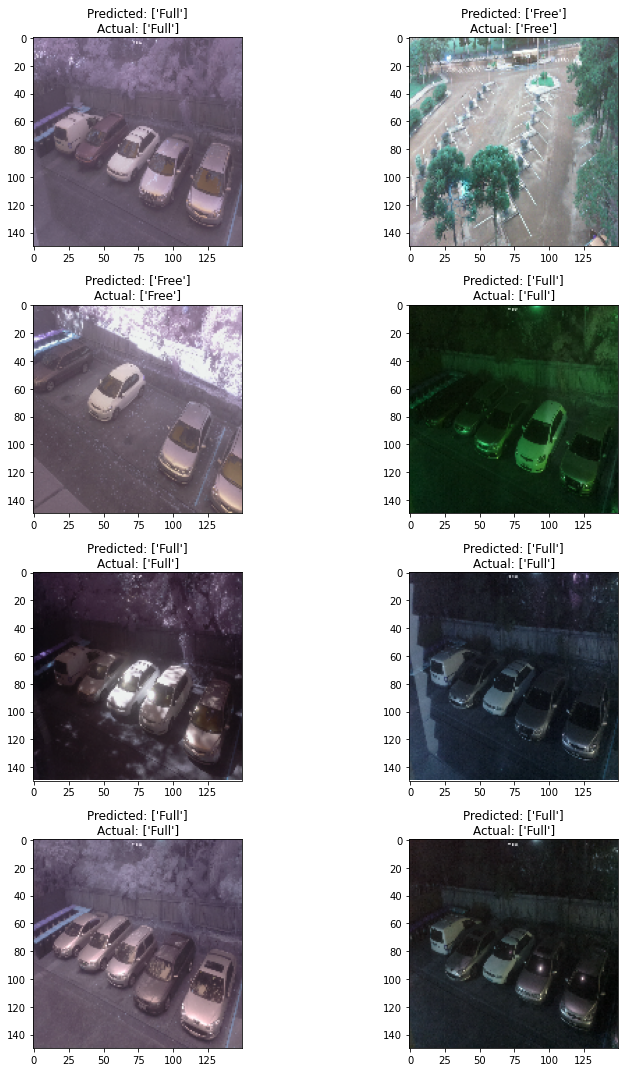

In [29]:
# predicted properly (show 8 images)
warnings.filterwarnings('always', 'ignore')

count = 0
fig, ax = plt.subplots(4, 2)
fig.set_size_inches(12, 15)
for i in range (4):
    for j in range (2):
        ax[i, j].imshow(X_valid[prop_class[count]])
        ax[i, j].set_title("Predicted: "+str(le.inverse_transform([pred_digits[prop_class[count]]]))
                           +"\nActual: "+str(le.inverse_transform([np.argmax([y_valid[prop_class[count]]])])))
        count += 1
plt.tight_layout()

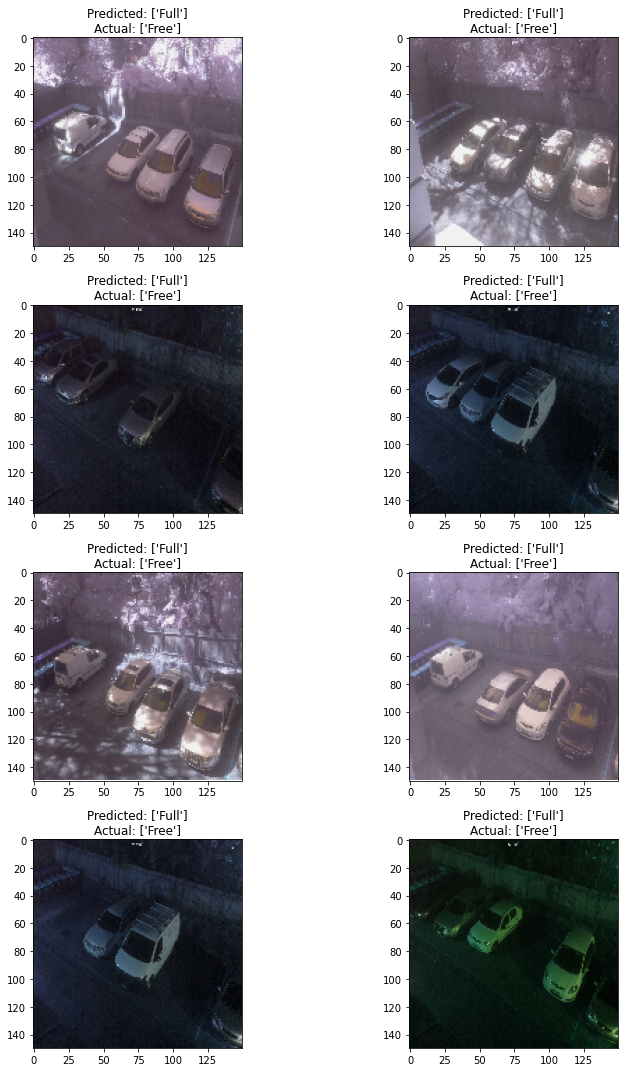

In [30]:
# predicted wrong (show 8 images)
warnings.filterwarnings('always', 'ignore')

count = 0
fig, ax = plt.subplots(4, 2)
fig.set_size_inches(12, 15)
for i in range (4):
    for j in range (2):
        ax[i, j].imshow(X_valid[mis_class[count]])
        ax[i, j].set_title("Predicted: "+str(le.inverse_transform([pred_digits[mis_class[count]]]))
                           +"\nActual: "+str(le.inverse_transform([np.argmax([y_valid[mis_class[count]]])])))
        count += 1
plt.tight_layout()

In [31]:
# accuracy
print('validation에 대한 분류 정확도:', round(acc/len(y_valid), 2))

validation에 대한 분류 정확도: 0.87


## Testing
학습에 사용된 이미지와 유사한 각도의 주차장 이미지 수집
- 구글에서 Full과 Free 각각 50장의 이미지 수집
- 분류 정확도를 확인하기 위해 클래스 분류
- 이미지 크롭, 파일 확장자 통일, 파일명 통일 등 전처리 완료

In [32]:
# directory
test_Free_DIR = os.path.join(data_DIR, 'random_Free')
test_Full_DIR = os.path.join(data_DIR, 'random_Full')

In [33]:
# setting
test_X = [] # store image array
test_Z = [] # store image label

In [34]:
# load data
img_load(test_X, test_Z, 'Free', test_Free_DIR)
print(len(test_X))

img_load(test_X, test_Z, 'Full', test_Full_DIR)
print(len(test_X))

 18%|█▊        | 9/50 [00:00<00:00, 76.86it/s]

50


100%|██████████| 50/50 [00:00<00:00, 64.66it/s]

100


In [35]:
# check test_X
print('전체 이미지 수:', len(test_X))
print('세로:', len(test_X[1]))
print('가로:', len(test_X[1][1]))
print('세로x가로 첫번째 픽셀값:', test_X[1][1][1]) # pixcel values for each color channels (RGB)

전체 이미지 수: 100
세로: 150
가로: 150
세로x가로 첫번째 픽셀값: [59 65 61]


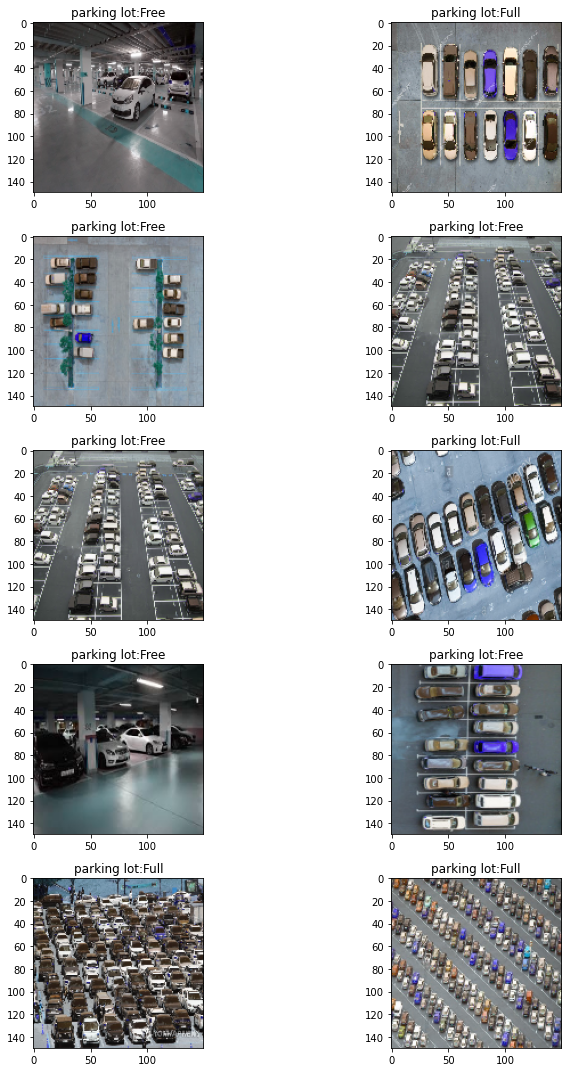

In [36]:
# check 10 random images
fig, ax = plt.subplots(5, 2)
fig.set_size_inches(12, 15)

for i in range(5):
    for j in range(2):
        num = random.randint(0, len(test_X)) # select random image number
        
        ax[i, j].imshow(test_X[num])                   # load image
        ax[i, j].set_title('parking lot:'+test_Z[num]) # attach label

plt.tight_layout()

In [37]:
# label encoder
le = LabelEncoder()
test_Y = le.fit_transform(test_Z)
test_Y = to_categorical(test_Y, 2)


# convert test_X
test_X = np.array(test_X) # copy
test_X = test_X/255       # convert values into range 0~1


# predict test_X
test_pred = model.predict(test_X)
test_pred_digits = np.argmax(test_pred, axis=1)


# classified indexes
i = 0
test_acc = 0
test_prop_class = []
test_mis_class = []

for i in range(len(test_Y)):
    if(np.argmax(test_Y[i]) == test_pred_digits[i]):  # if actual and prection has same index
        test_prop_class.append(i)                     # predicted properly
        test_acc += 1                                 # count
    else:
        test_mis_class.append(i)                      # predicted wrong

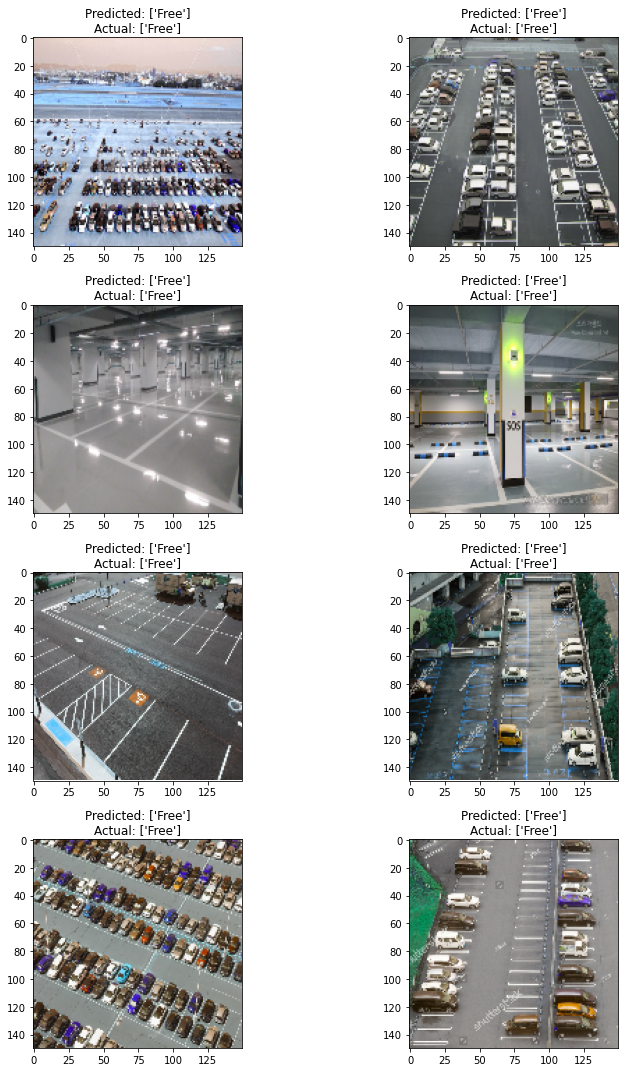

In [38]:
# predicted properly (show 8 images)
warnings.filterwarnings('always', 'ignore')

count = 0
fig, ax = plt.subplots(4, 2)
fig.set_size_inches(12, 15)
for i in range (4):
    for j in range (2):
        ax[i, j].imshow(test_X[test_prop_class[count]])
        ax[i, j].set_title("Predicted: "+str(le.inverse_transform([test_pred_digits[test_prop_class[count]]]))
                           +"\nActual: "+str(le.inverse_transform([np.argmax([test_Y[test_prop_class[count]]])])))
        count += 1
plt.tight_layout()

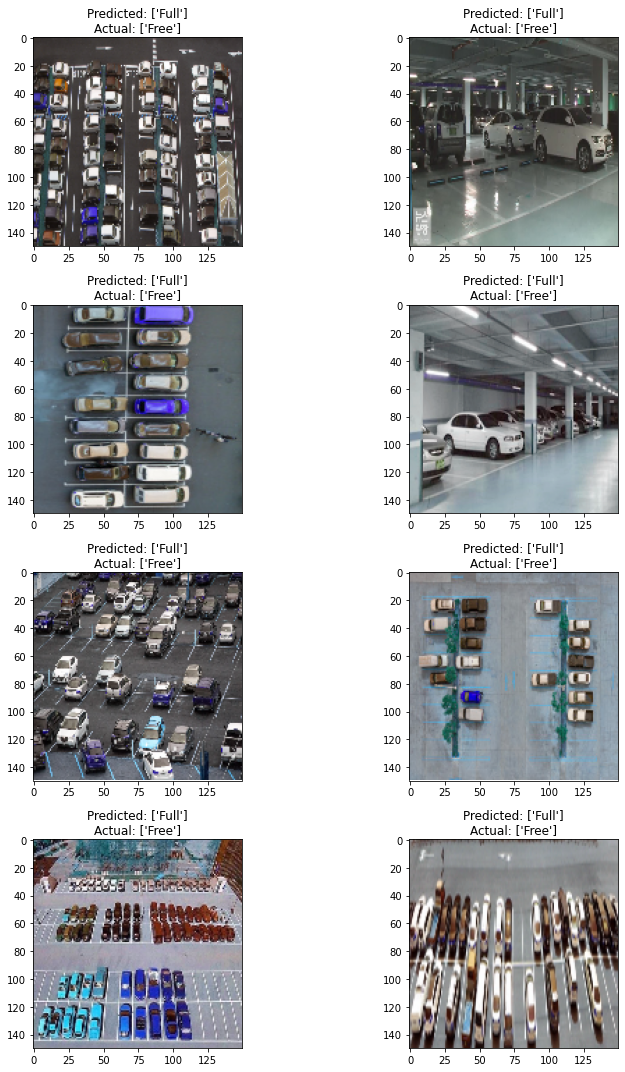

In [39]:
# predicted wrong (show 8 images)
warnings.filterwarnings('always', 'ignore')

count = 0
fig, ax = plt.subplots(4, 2)
fig.set_size_inches(12, 15)
for i in range (4):
    for j in range (2):
        ax[i, j].imshow(test_X[test_mis_class[count]])
        ax[i, j].set_title("Predicted: "+str(le.inverse_transform([test_pred_digits[test_mis_class[count]]]))
                           +"\nActual: "+str(le.inverse_transform([np.argmax([test_Y[test_mis_class[count]]])])))
        count += 1
plt.tight_layout()

In [40]:
# accuracy
print('랜덤 이미지에 대한 분류 정확도:', round(test_acc/len(test_Y), 2))

랜덤 이미지에 대한 분류 정확도: 0.68


참고
- [CNN, Convolutional Neural Network 요약, *TAEWAN.KIM 블로그*](http://taewan.kim/post/cnn/)
- [케라스 CNN을 활용한 비행기 이미지 분류하기, *갈루아의 반서재*](https://antilibrary.org/1980)
- [[keras]자신만의 이미지 데이터로 CNN 적용해보기, *흰고래의꿈*](https://twinw.tistory.com/252)
- [이미지 전처리 ImgaeDataGenerator 클래스, *Keras Documentation*](https://keras.io/ko/preprocessing/image/)